# Atlas Segmentation - Medical Image Segmentation and Applications (MISA)

This notebook contains all necessary code to segment brain tissues (WM, GM, CSF) using probabilistic atas based approach.

**TODO:**
1. Markov Random Field in `segment_using_tissue_models_and_atlas` where probabilities are multiplied to form a posterior.
2. In `segment_using_tissue_models_and_atlas`, handle bins>100 to be CSF probabilities.

## 1. Imports

In [50]:
import os
import subprocess
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr
from skimage import exposure
import matplotlib.pyplot as plt
from EM import NiftiManager, Evaluate, ElastixTransformix, FileManager, BrainAtlasManager

pp = pprint.PrettyPrinter(indent=4)

## 2. Helper functions

In [51]:
NM    = NiftiManager()
EVAL  = Evaluate()
ET    = ElastixTransformix()
FM    = FileManager()
BM    = BrainAtlasManager()

In [52]:
def skull_stripping(image, label):
    '''Performs only skull stripping and returns the volume with the label tissues only.
    
    Args:
        image ('np.array'):
            An intensity volume for the brain in the form of a numpy array.
        
        label ('np.array'):
            The labels volume associated to the intensity volume passed as an image.

    Returns:
        The skull stripped volume in the same shape of the passed intensity volume. The output will still contain
        background labelled as 0 as a result of the multiplication. The output volume is a numpy array.
    '''
    # convert the labels to binary form, all tissues to 1, else is 0
    labels_mask   = np.where(label == 0, 0, 1)

    # multiply the image to get only the tissues
    return np.multiply(image, labels_mask)


In [53]:
print(ET.excute_cmd('elastix --version'))

elastix version: 4.200



In [54]:
test_path = 'test-set/testing-images'
test_labels_path = 'test-set/testing-labels'
test_masks_path = 'test-set/testing-mask'

test_volumes = sorted(glob(os.path.join(test_path, "*.nii.gz"), recursive=True))
test_labels = sorted(glob(os.path.join(test_labels_path, "*.nii.gz"), recursive=True))
test_masks = sorted(glob(os.path.join(test_masks_path, "*.nii.gz"), recursive=True))

# result examples
# 'test-set/testing-images\\1003.nii.gz'
# 'test-set/testing-labels\\1003_3C.nii.gz'
# 'test-set/testing-mask\\1003_1C.nii.gz'

## 3. Segmentation without EM

### (1.1) Tissue models: segmentation using just intensity information

In [55]:
test_index    = 10
subject_vol   = test_volumes[test_index]
subject_label = test_labels[test_index]

subject_id = subject_vol.split('\\')[-1].split('.')[0]

test_intensity_example, _  = NM.load_nifti(subject_vol)
test_intensity_example     = NM.min_max_normalization(test_intensity_example, 255).astype('uint8')   

test_label_example, _      = NM.load_nifti(subject_label)

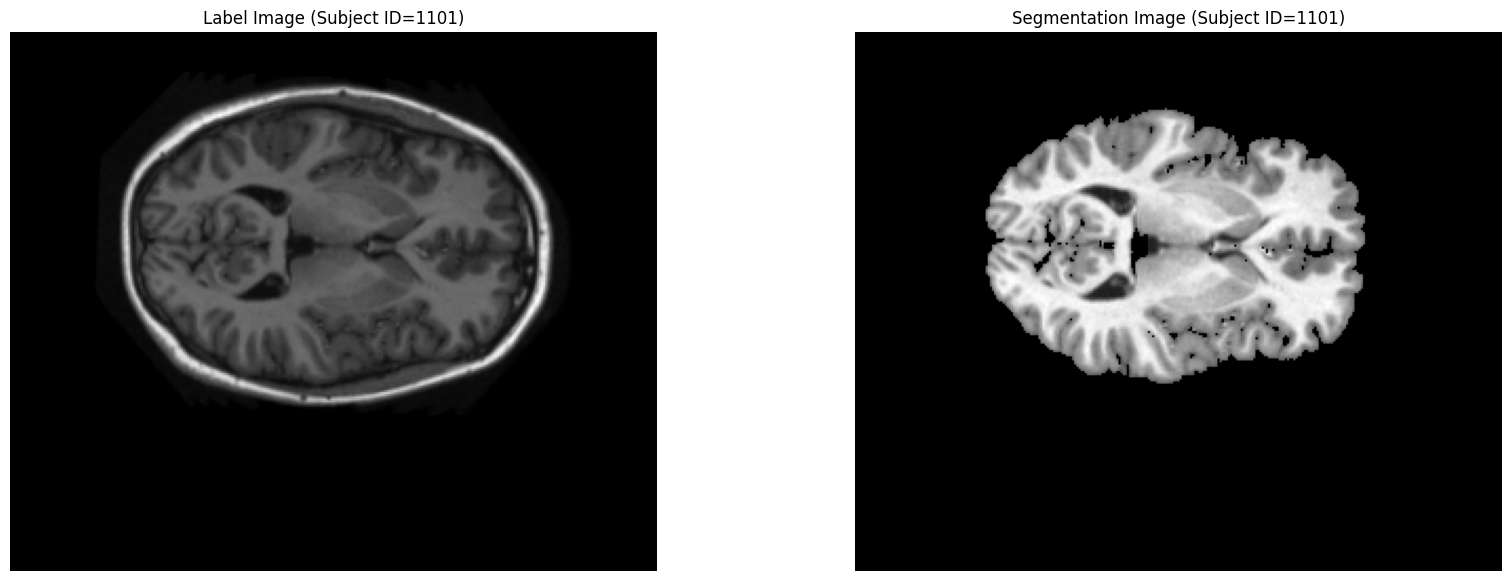

In [56]:
# perform skull stripping
skull_stripped = skull_stripping(test_intensity_example, test_label_example)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_intensity_example, skull_stripped, subject_id, slice=128)

In [57]:
# import tissue model csv
# fix labelling indexes
# in the saving, make sure to save without a header
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

In [58]:
segmentation_tissue_model, _ = BM.segment_using_tissue_models(skull_stripped, test_label_example, tissue_map_csv)

CSF DICE:  0.5012454858586104
GM DICE:  0.8966286786936227
WM DICE:  0.887851689399675


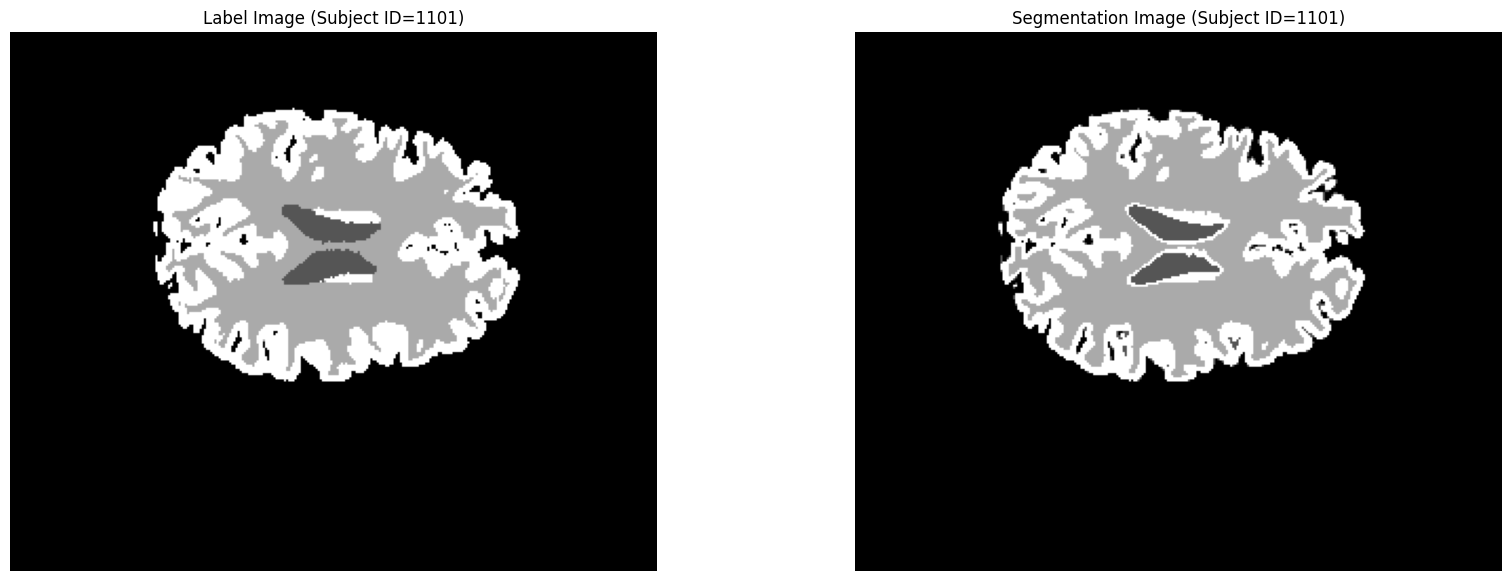

In [59]:
segmentation_tissue_model_bg  = segmentation_tissue_model == 0
segmentation_tissue_model_csf = segmentation_tissue_model == 1
segmentation_tissue_model_wm  = segmentation_tissue_model == 2
segmentation_tissue_model_gm  = segmentation_tissue_model == 3

labels_nifti_CSF              = test_label_example == 1
labels_nifti_WM               = test_label_example == 2
labels_nifti_GM               = test_label_example == 3

dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_tissue_model_csf)
dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_tissue_model_wm)
dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_tissue_model_gm)

print("CSF DICE: ", dice_csf)
print("GM DICE: ", dice_gm)
print("WM DICE: ", dice_wm)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_label_example, segmentation_tissue_model, subject_id, slice=148)

### (1.2) Label propagation: segmentation using just position information

To segment using the atlases, we need to register the test images and perform label propagation using the a reference frame. The reference frame for this task will be the averaged intensity atlas.

In [60]:
# register with float64 data volume
averaged_intensity_atlas_path = 'atlas_outputs/mean_intensity.nii.gz'
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

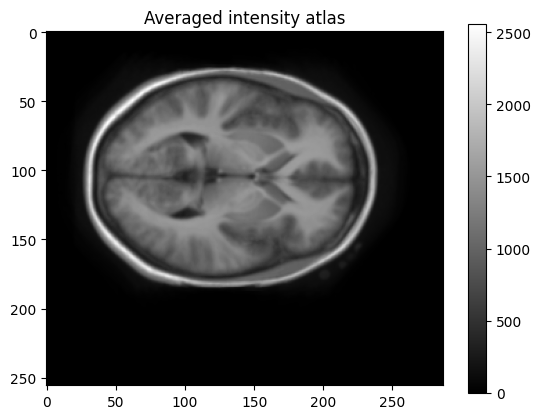

In [61]:
averaged_intensity_atlas, _ = NM.load_nifti(averaged_intensity_atlas_path)

NM.show_nifti(averaged_intensity_atlas, title="Averaged intensity atlas", slice=128)

**Run the next cell only when you need to register and perform label propagation**

In [36]:
# atlas_csf_dir = 'atlas_outputs/mean_csf.nii.gz'
# atlas_wm_dir  = 'atlas_outputs/mean_wm.nii.gz'
# atlas_gm_dir  = 'atlas_outputs/mean_gm.nii.gz'

# for test_volume, test_label, test_mask in tqdm(zip(test_volumes, test_labels, test_masks)):
#     image_id = test_volume.replace('\\', '/').split("/")[-1].split(".")[0]
#     reg_moving_name = averaged_intensity_atlas_path.replace("\\", "/").split("/")[-1].split(".")[0]

#     # register an example test volume to the averaged intensity atlas
#     ET.register_elastix(
#         fixed_path = test_volume, 
#         moving_path = averaged_intensity_atlas_path, 
#         fMask = test_mask,
#         reg_params = reg_params,
#         create_dir_callback = FM.create_directory_if_not_exists,
#         excute_cmd_callback = ET.excute_cmd)

#     # perform label propagation to csf atlas
#     ET.label_propagation_transformix(
#         fixed_path = test_volume, 
#         moving_path = atlas_csf_dir, 
#         input_label = atlas_csf_dir,
#         transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
#         replace_text_in_file_callback = FM.replace_text_in_file,
#         create_dir_callback = FM.create_directory_if_not_exists,
#         excute_cmd_callback = ET.excute_cmd)

#     # perform label propagation to csf atlas
#     ET.label_propagation_transformix(
#         fixed_path = test_volume, 
#         moving_path = atlas_wm_dir, 
#         input_label = atlas_wm_dir,
#         transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
#         replace_text_in_file_callback = FM.replace_text_in_file,
#         create_dir_callback = FM.create_directory_if_not_exists,
#         excute_cmd_callback = ET.excute_cmd)

#     # perform label propagation to csf atlas
#     ET.label_propagation_transformix(
#         fixed_path = test_volume, 
#         moving_path = atlas_gm_dir, 
#         input_label = atlas_gm_dir,
#         transform_path = f'output/images/output_{image_id}/{reg_moving_name}/TransformParameters.1.txt',
#         replace_text_in_file_callback = FM.replace_text_in_file,
#         create_dir_callback = FM.create_directory_if_not_exists,
#         excute_cmd_callback = ET.excute_cmd)
    

20it [58:53, 176.66s/it]


After registering to the atlas reference space and performing label propagation, now we can perform segmentation using position information from the atlases.

In [63]:
concatenated_atlas = np.column_stack((atlas_csf.flatten(), atlas_wm.flatten(), atlas_gm.flatten()))
concatenated_atlas.shape

(18808832, 3)

In [66]:
# load the registered test volume
volumes_output_path = f'output/images/'

registered_volumes = sorted(glob(os.path.join(volumes_output_path, '**', "result.1.nii"), recursive=True))

In [67]:
registered_volumes

['output/images\\output_1003\\mean_intensity\\result.1.nii',
 'output/images\\output_1003\\template\\result.1.nii',
 'output/images\\output_1004\\mean_intensity\\result.1.nii',
 'output/images\\output_1004\\template\\result.1.nii',
 'output/images\\output_1005\\mean_intensity\\result.1.nii',
 'output/images\\output_1005\\template\\result.1.nii',
 'output/images\\output_1018\\mean_intensity\\result.1.nii',
 'output/images\\output_1019\\mean_intensity\\result.1.nii',
 'output/images\\output_1023\\mean_intensity\\result.1.nii',
 'output/images\\output_1024\\mean_intensity\\result.1.nii',
 'output/images\\output_1025\\mean_intensity\\result.1.nii',
 'output/images\\output_1038\\mean_intensity\\result.1.nii',
 'output/images\\output_1039\\mean_intensity\\result.1.nii',
 'output/images\\output_1101\\mean_intensity\\result.1.nii',
 'output/images\\output_1104\\mean_intensity\\result.1.nii',
 'output/images\\output_1107\\mean_intensity\\result.1.nii',
 'output/images\\output_1110\\mean_intensi

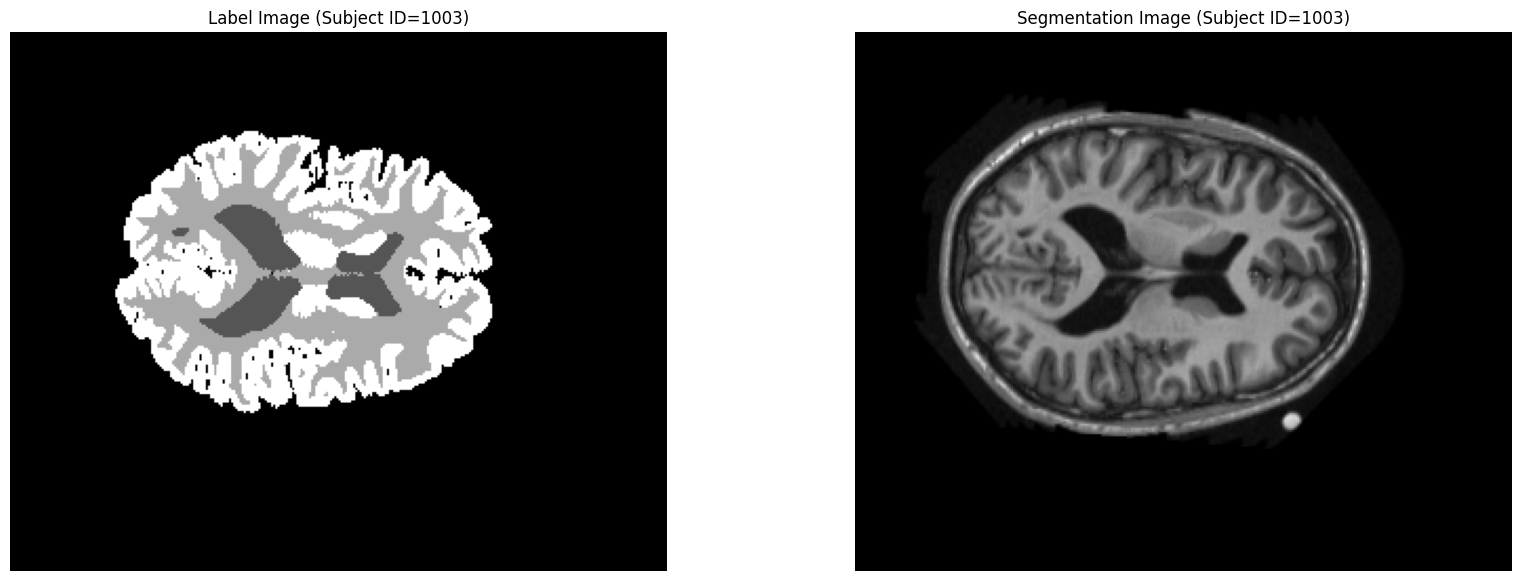

In [83]:
# take a single example to create the function
registered_volume_test_path = 'test-set/testing-images/1025.nii.gz'
registered_label_test_path  = 'test-set/testing-labels/1025_3C.nii.gz'

registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)
registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   

registered_label_test, _ = NM.load_nifti(registered_label_test_path)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1003, slice=148)

In [84]:
# note that the shape matches the registered image, thus we can perform the segmentation!
registered_volume_test.flatten().shape 

(20447232,)

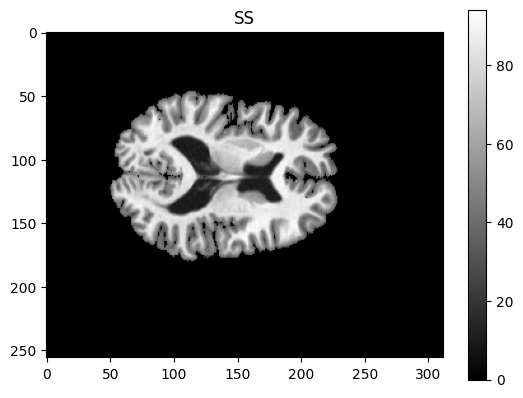

In [85]:
# before we segment the test, we perform skull stripping on it
registered_volume_test_ss = skull_stripping(registered_volume_test, registered_label_test)

NM.show_nifti(registered_volume_test_ss, title="SS", slice=148)

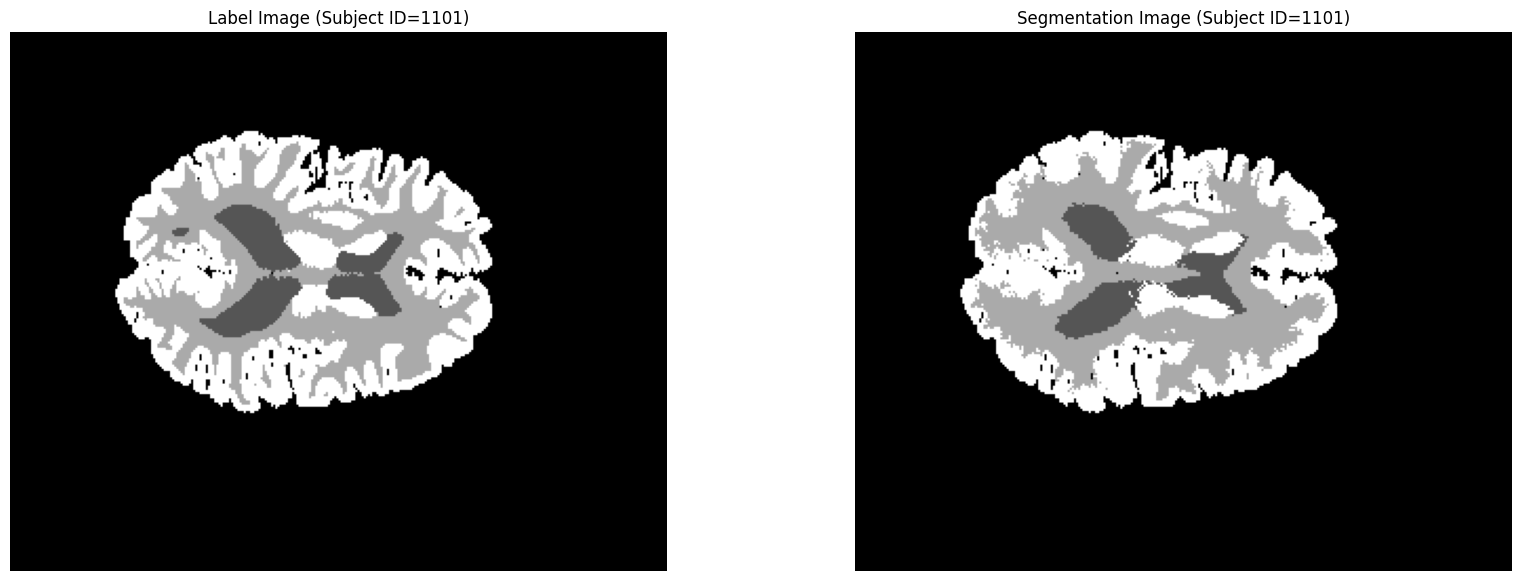

In [88]:
atlas_csf = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_csf/result.nii')[0]
atlas_wm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_wm/result.nii')[0]
atlas_gm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_gm/result.nii')[0]

segmented_image, _ = BM.segment_using_tissue_atlas(registered_volume_test_ss, registered_label_test, atlas_csf, atlas_wm, atlas_gm)

NM.show_label_seg_nifti(registered_label_test, segmented_image, subject_id, slice=148)

### (1.3) Tissue models & label propagation: multiplying both results: segmentation using intensity & position information

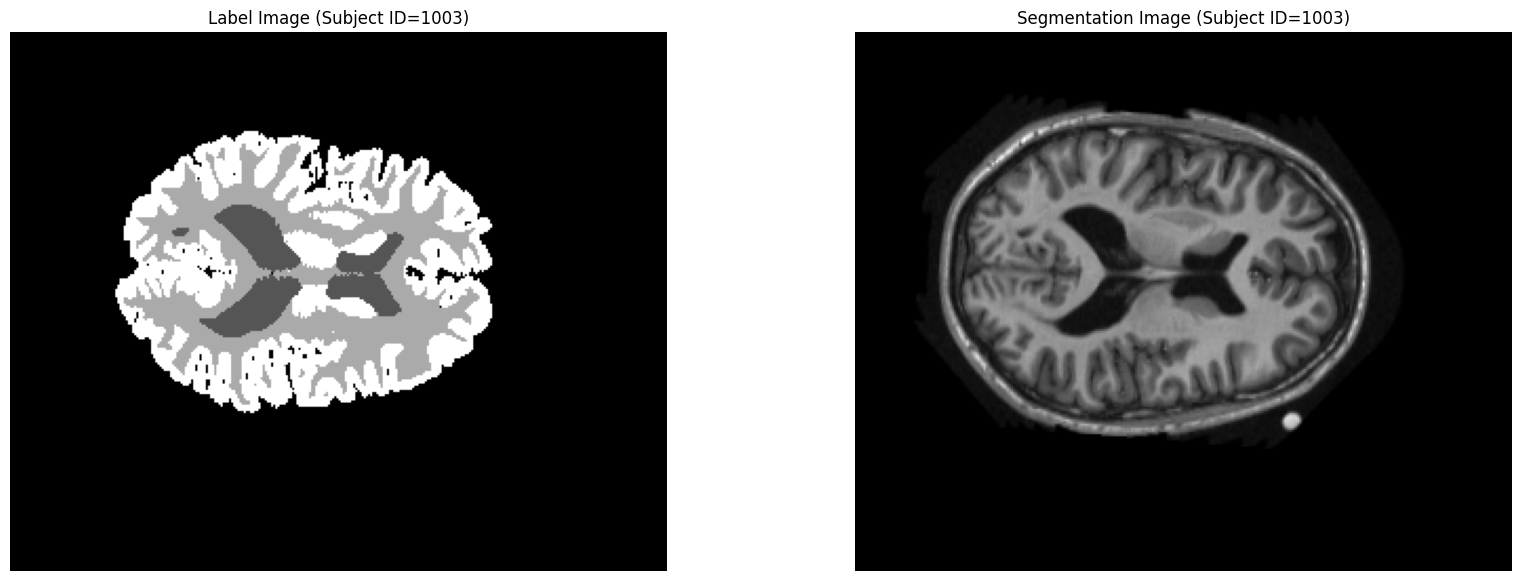

In [89]:
# take a single example to create the function
registered_volume_test_path = 'test-set/testing-images/1025.nii.gz'
registered_label_test_path  = 'test-set/testing-labels/1025_3C.nii.gz'

registered_volume_test, _ = NM.load_nifti(registered_volume_test_path)
registered_volume_test    = NM.min_max_normalization(registered_volume_test, 255).astype('uint8')   

registered_label_test, _ = NM.load_nifti(registered_label_test_path)

NM.show_label_seg_nifti(registered_label_test, registered_volume_test, 1003, slice=148)

In [29]:
# taking into account as well the intensity information
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

CSF DICE:  0.8992296367841893
GM DICE:  0.9566152402316423
WM DICE:  0.9247900070477527


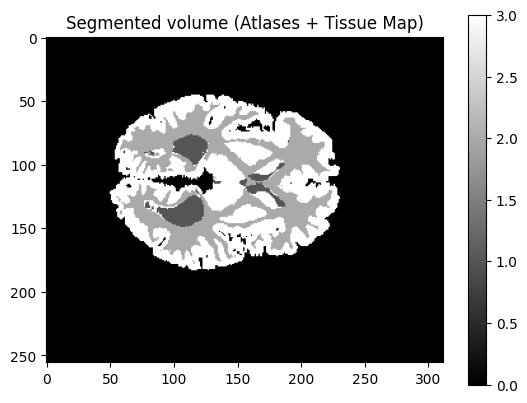

In [93]:
atlas_csf = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_csf/result.nii')[0]
atlas_wm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_wm/result.nii')[0]
atlas_gm  = NM.load_nifti('output/labels/output_1025/atlas_outputs/mean_gm/result.nii')[0]

segmented_image, _ = BM.segment_using_tissue_models_and_atlas(
    registered_volume_test,
    registered_label_test,
    tissue_map_csv,
    atlas_csf, 
    atlas_wm, 
    atlas_gm
)

segmented_image_bg  = segmented_image == 0
segmented_image_csf = segmented_image == 1
segmented_image_wm  = segmented_image == 2
segmented_image_gm  = segmented_image == 3

labels_nifti_CSF              = registered_label_test == 1
labels_nifti_WM               = registered_label_test == 2
labels_nifti_GM               = registered_label_test == 3

dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmented_image_csf)
dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmented_image_wm)
dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmented_image_gm)

print("CSF DICE: ", dice_csf)
print("GM DICE: ", dice_gm)
print("WM DICE: ", dice_wm)

NM.show_nifti(segmented_image, title="Segmented volume (Atlases + Tissue Map)", slice=137)

## 4. Segmentation by EM from previous session. We will refine using just intensity information an initial segmentation obtained in different ways

### (2.1) Using k-Means initialisation (algorithm from past session): segmentation using intensity information

### (2.2) Using tissue models initialisation (1.1): segmentation using intensity information

In [63]:
tissue_map_csv = 'atlas_outputs/tissue_model_probability_data.csv'

subject_vol   = 'test-set/testing-images\\1101.nii.gz'
subject_label = 'test-set/testing-labels\\1101_3C.nii.gz'

subject_id = subject_vol.split('\\')[-1].split('.')[0]

test_intensity_example, _  = NM.load_nifti(subject_vol)
test_intensity_example     = NM.min_max_normalization(test_intensity_example, 255).astype('uint8')   

test_label_example, _      = NM.load_nifti(subject_label)

In [64]:
test_intensity_example.shape

(256, 307, 256)

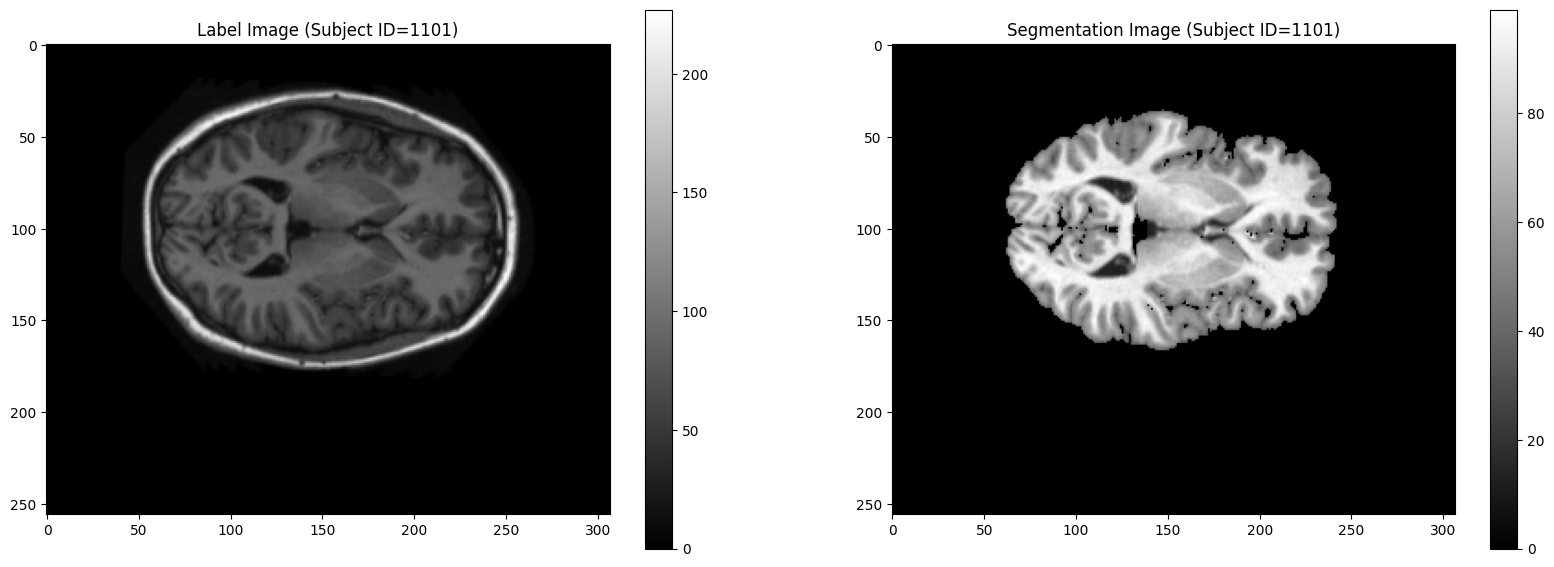

In [22]:
# perform skull stripping
skull_stripped = skull_stripping(test_intensity_example, test_label_example)

# display both intensity volume before and after skull stripping
NM.show_label_seg_nifti(test_intensity_example, skull_stripped, subject_id, slice=128)

In [72]:
print(skull_stripped.shape)
segmentation_tissue_model = segment_using_tissue_models(skull_stripped, tissue_map_csv)
print(segmentation_tissue_model.shape)

(256, 307, 256)
(256, 307, 256)


In [73]:
# flattened_seg = segmentation_tissue_model.flatten()
# print(len(flattened_seg))
# print(len(flattened_seg[flattened_seg==0]))
# print(len(flattened_seg[flattened_seg==1]))
# print(len(flattened_seg[flattened_seg==2]))
# print(len(flattened_seg[flattened_seg==3])) #GM has the most

In [74]:
labels = segmentation_tissue_model.flatten() # new labels

# we have to substract 1 as inside the function `segmentation_tissue_model`, we add 1 to the segmentation argmax predictions
# we also have to remove the 0 background 
cluster_labels = labels[labels!=0] - 1
cluster_labels.shape

(1450561,)

In [77]:
np.unique(cluster_labels)

array([0, 1, 2])

In [57]:
alpha_k        = np.array([np.sum([cluster_labels == i]) / len(cluster_labels) for i in range(3)]) # ratio for each cluster
print(alpha_k)
print(np.sum(alpha_k))

[0.03887393 0.43327719 0.52784888]
1.0


In [71]:
[i for i in range(1,4)]

[1, 2, 3]

In [95]:
skull_stripped.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [88]:
# np.ones(shape=(3,2))
clusters_masks = [labels == k for k in range(1, 4)]

# Calculate the mean for each cluster
cluster_means = np.array([np.mean(skull_stripped.flatten()[cluster_mask]) for cluster_mask in clusters_masks])

cluster_means_final = cluster_means[:, np.newaxis]

In [96]:
clusters_masks

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [89]:
print(cluster_means)
print(cluster_means.shape)

print(cluster_means_final)
print(cluster_means_final.shape)

[29.67662133 82.79989499 53.38696996]
(3,)
[[29.67662133]
 [82.79989499]
 [53.38696996]]
(3, 1)


CSF DICE:  0.5012454858586104
GM DICE:  0.8966286786936227
WM DICE:  0.887851689399675


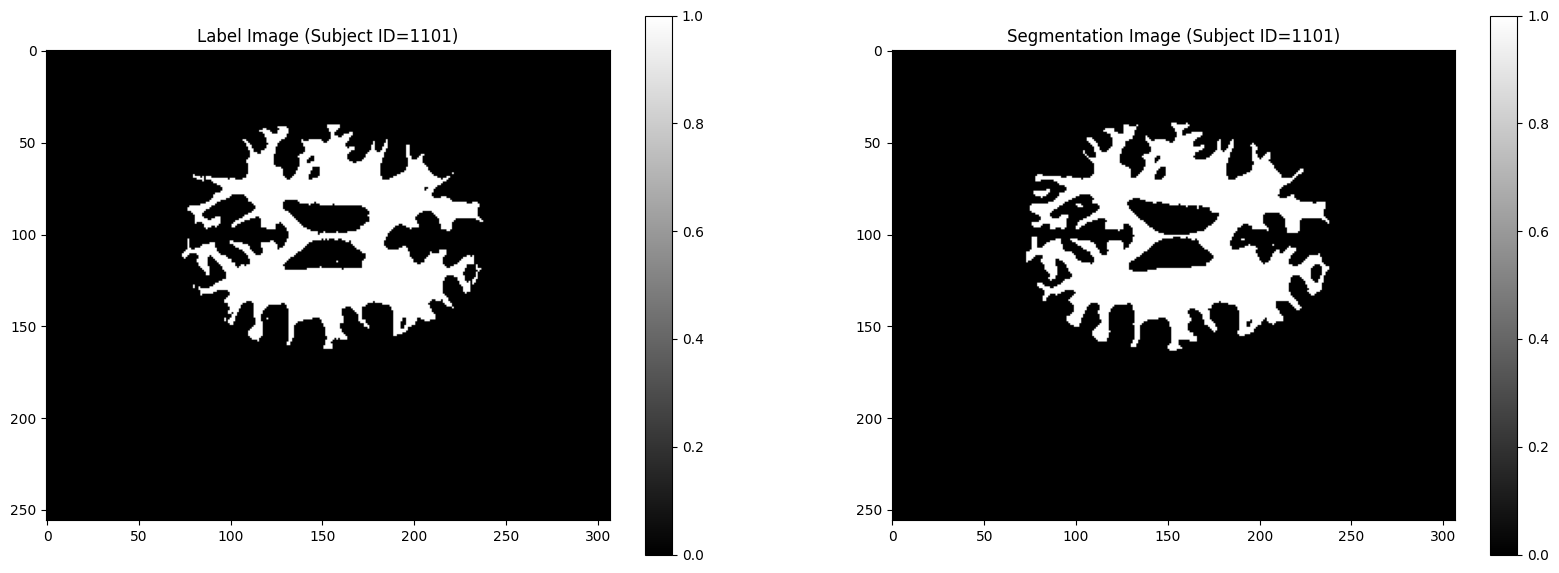

In [30]:
# segmentation_tissue_model_bg  = segmentation_tissue_model == 0
# segmentation_tissue_model_csf = segmentation_tissue_model == 1
# segmentation_tissue_model_wm  = segmentation_tissue_model == 2
# segmentation_tissue_model_gm  = segmentation_tissue_model == 3

# labels_nifti_CSF              = test_label_example == 1
# labels_nifti_WM               = test_label_example == 2
# labels_nifti_GM               = test_label_example == 3

# dice_csf    = EVAL.calc_dice_coefficient(labels_nifti_CSF, segmentation_tissue_model_csf)
# dice_wm     = EVAL.calc_dice_coefficient(labels_nifti_WM, segmentation_tissue_model_wm)
# dice_gm     = EVAL.calc_dice_coefficient(labels_nifti_GM, segmentation_tissue_model_gm)

# print("CSF DICE: ", dice_csf)
# print("GM DICE: ", dice_gm)
# print("WM DICE: ", dice_wm)

# # display both intensity volume before and after skull stripping
# NM.show_label_seg_nifti(labels_nifti_WM, segmentation_tissue_model_wm, subject_id, slice=148)